**Import necessary packages**

In [1]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, NLocal, PauliTwoDesign
# from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD # chemistry simulation ansatzes, for example the UCCSD ansatz prepares a state where tuning the parameters turns excitations on and off
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
import numpy as np 
from numpy import sqrt, pi, linalg
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.result import marginal_counts
from IPython.display import display, clear_output
from qiskit import Aer, transpile, assemble
from qiskit.utils import QuantumInstance
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_bloch_vector, plot_state_qsphere
from qiskit.quantum_info import Statevector, Operator, Pauli
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp, PauliOp
from qiskit_optimization import QuadraticProgram
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, execute
IBMQ.load_account()
provider = IBMQ.get_provider(group='open', project='main')

**Construct general circuit ansatz**

In [2]:
# Prepare general State Circuit (n Qubit)-Multi-control qubit
def PrepareState_Gen(parameter,q = 2):
    # Multi control U3 gate
    def MCUGate(p1,p2,ctrlqubit):
        ctrl = QuantumCircuit(1, name='U3')
         # U3 decompose
        ctrl.rz(p2,0)
        ctrl.rx(-np.pi/2,0)
        ctrl.rz(p1,0)
        ctrl.rx(np.pi/2,0)
        ctrl.rz(-p2,0)
        # U3 decompose
        ctrl = ctrl.to_gate().control(ctrlqubit)
        return ctrl
    # State's bit string converter
    def Bitstring(inter,leng):
        result = []
        while inter >= 2:
            d = inter % 2
            inter = inter//2
            result.append(d)
        result.append(inter)
        for i in range(leng-len(result)):
            result.append(0)
        return result

    qg = QuantumRegister(q,'q')
    qc = QuantumCircuit(qg)
    qc.u(parameter[0],parameter[1],-parameter[1],q-1)
    qc.barrier(range(q))
    theta = 2
    # Apply multi-control qubit gate
    for i in range(q-1):
        listctrl = [ i+n+1 for n in range(q-i-1)]
        listctrl.append(i)
        for j in range(2**(q-i-1)):
            bitstring = Bitstring(j,q-i-1)
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1)
            qc.append(MCUGate(parameter[theta],parameter[theta+1],q-i-1),listctrl) 
            for n in range(q-i-1):
                if bitstring[n] == 0:
                    qc.x(i+n+1) 
            theta +=2
        qc.barrier(range(q))
    return qc

**Construct Pauli's expectation**

*Exact classical simulator expectation*

In [3]:
def Expectation_Exact(gate=None,q1=None,q2=None,circ=None):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    if gate == "Z":
        P1 = Statevector(qc).probabilities([q1]) # P(i)
        P2 = Statevector(qc).probabilities([q2]) # P(j)
        P00 = Statevector(qc).probabilities([q1,q2]) # P(i,j)
        firesult=(4*P00[0])-1-(2*(P1[0])-1)-(2*(P2[0])-1) # =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        P = Statevector(qc).probabilities([q1]) # P(i)
        firesult=(2*P[0]-1) # =(2P(i=0)-1)
    return firesult

*Idea, noise and real backend running of expectation*

In [4]:
def Expectation_backend(gate=None,q1=None,q2=None,circ=None,realbackend=provider.get_backend('ibmq_bogota')):
    qc = QuantumCircuit(circ.num_qubits,circ.num_qubits)
    qc.append(circ,[i for i in range(circ.num_qubits)])
    
    # For Idea and noise model simulator
    backend = Aer.get_backend('qasm_simulator')
    noise_model = NoiseModel.from_backend(realbackend)
    # For real backend running
    # backend = realbackend
    shot=20000
    
    # Get string of state
    qubit = qc.num_qubits
    bitq1 = '' # Get string of |...01...> state
    bitq2 = '' # Get string of |...10...> state
    bit0 = ''  # Get string of |...00...> state
    for i in range(qubit):
        bit0 += '0'
        if i == q1:
            bitq1 += '1'
            bitq2 += '0'
        elif i == q2:
            bitq2 += '1'
            bitq1 += '0'
        else:
            bitq1 += '0'
            bitq2 += '0'
    bit0 = bit0[::-1]
    bitq1 = bitq1[::-1]
    bitq2 = bitq2[::-1]
    
    if gate == "Z":
        qc.measure([q1,q2],[q1,q2])
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj,noise_model=noise_model).result().get_counts(qc)
        for output in [bit0,bitq1,bitq2]:
            if output in result:
                result[output]/=shot
            else:
                result[output] = 0
        firesult=4*(result[bit0])-1-(2*(result[bit0]+result[bitq1])-1)-(2*(result[bit0]+result[bitq2])-1)# =(4*P(i,j=0)-1-(2P(i=0)-1)-(2P(j=0)-1))
    elif gate == "X":
        qc.h(q1) # Apply H gate to apply X basic measurement
        qc.measure(q1,q1)  
        tqc = transpile(qc, backend,optimization_level=3)
        qobj = assemble(tqc,shots=shot)
        result = backend.run(qobj,noise_model=noise_model).result().get_counts(qc)
        if bit0 in result:
            result[bit0]/=shot
        else:
            result[bit0] = 0
        firesult=(2*(result[bit0])-1)# =(2P(i=0)-1)
    return firesult

**Ising VQE method's function**

The VQE function will be built from the expectation function constructed above 

*Exact classical simulator*

In [1]:
def vqe_exact(parameter, q,h):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_Exact("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_Exact("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton 

*Backend running*

In [6]:
def vqe_backend(parameter, q,h):
    qc = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
    qc = qc.assign_parameters(parameter)
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Expectation_backend("X",i,circ=qc)
        if i < (q-1):
            Zterm = Expectation_backend("Z",i,i+1,circ = qc)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

The previous ones, one IBM real backend job corresponds to one Ising term, so we need many jobs (time) to compute the expectation of the whole Ising Hamiltonian as well as results of quantum function derivative. I thus optimize the code to compute entirely our objective function by one IBM job

**Ising VQE method's optimized function**

*Exact classical simulator optimized running*

In [7]:
def vqe_exact_opt(parameter,q,h,file=None,realbackend = Aer.get_backend('statevector_simulator')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = RealAmplitudes(q, entanglement='linear', reps=1)
    qc = qc.assign_parameters(parameter)

    # For noise model simulator
    # backend = Aer.get_backend('statevector_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    # For exact classical simulator 
    backend = realbackend


    # Function turning out Ising term's expectation values from backend running result 
    def Res(result,p,gate):
        value = 0
        if gate == 'X':
            for index in result:
                if index[::-1][p:(p+1)] == '0':
                    value += result[index]
        elif gate == 'Z':
            for index in result:
                if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                    value += result[index]
        return (2*value -1)
        
    # Ising Hamilton circuit       
    Z_cir =  QuantumCircuit(q)
    Z_cir.append(qc,[i for i in range(q)])
    X_cir =  QuantumCircuit(q)
    X_cir.append(qc,[i for i in range(q)])
    X_cir.h([i for i in range(q)])
    Hamil_cir = [Z_cir,X_cir]
    
    # Backend running
    job = execute(Hamil_cir, backend) 
    result = job.result().get_counts()

    # Ising Hamilton expectation value
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = Res(result[1],i,'X')
        if i < (q-1):
            Zterm = Res(result[0],i,'Z')
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

    # File write
    file.write(f'\n Job ID: {job.job_id()} \n ')
    file.write(f'Parameter: {parameter} \n ')
    file.write(f'Result: {result} \n ')
    file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

*Backend optimized running*

In [8]:
def vqe_backend_opt(parameter,q,h,meas_map = [[0],[1],[2]],file=None,shots=20000,realbackend = provider.get_backend('ibmq_belem')):
    # parameters = ParameterVector('θ', 2**(q+1)-2)
    # qc = PrepareState_Gen(parameters,q)
    qc = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
    qc = qc.assign_parameters(parameter)

    # For Idea and noise model simulator
    # backend = Aer.get_backend('qasm_simulator')
    # noise_model = NoiseModel.from_backend(realbackend)
    # For real backend running
    backend = realbackend
    
    # Create a circuit corresponding to a Ising term expectation value
    def Qcir(gate=None,p=None,q = q,qc = qc):
        if gate == 'Z':
            cir = QuantumCircuit(q,2)
            cir.append(qc,[i for i in range(q)])
            cir.measure([p,p+1], [0,1])
        elif gate == 'X':
            cir = QuantumCircuit(q,1)
            cir.append(qc,[i for i in range(q)])
            cir.h(p)
            cir.measure(p,0)
        cir = transpile(cir, backend=backend,optimization_level=3)
        return cir

    # Create propability results from backend running result
    def Check(result,index,shots = shots):
        if index not in result:
            result[index]=0
        return result[index]/shots

    # Ising Hamilton circuit     
    Z_cir = [i for i in range(q-1)]
    X_cir = [i for i in range(q)]
    for i in range(q):
        X_cir[i] = Qcir('X',i)
        if i < (q-1):
            Z_cir[i] = Qcir('Z',i)
    Hamil_cir = []
    Hamil_cir = Z_cir+X_cir
    
    # Backend running
    Assem = assemble(Hamil_cir, backend,meas_map=meas_map,shots=shots)
    job = backend.run(Assem)    
    result = job.result().get_counts()
    
    # Ising Hamilton expectation value
    Ising_Hamilton = 0
    for i in range(q):
        Xterm = 2*Check(result[q+i-1],'0')-1
        if i < (q-1):
            Zterm = 4*(Check(result[i],'00'))-1-(2*(Check(result[i],'00')+Check(result[i],'01'))-1)-(2*(Check(result[i],'00')+Check(result[i],'10'))-1)
        elif i == (q-1):
            Zterm = 0
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm

    # File write
    file.write(f'\n Job ID: {job.job_id()} \n ')
    file.write(f'Parameter: {parameter} \n ')
    file.write(f'Result: {result} \n ')
    file.write(f'Ising Hamilton result: {Ising_Hamilton} \n')
    return Ising_Hamilton

**Exact classical diagonal method**

*Generate Ising Hamiltonian matrix for classical solver*


In [9]:
def Ising_Hamilton(q,h):
    Ising_Hamilton = 0
    for i in range(q):
        Zterm  = 1
        Xterm  = 1
        for j in range(q-1):
            if j == i:
                Zterm = Zterm^Z^Z
                Xterm  = Xterm^X^I
            elif i == (q-1) and j == (i-1):
                Xterm = Xterm^I^X
                Zterm = 0
            else:
                Zterm = Zterm^I
                Xterm = Xterm^I
        Ising_Hamilton = Ising_Hamilton + Zterm + h*Xterm
    return Ising_Hamilton

*Ising classical solver*

In [10]:
q = 2
h = 1.5

# Haminlton matrix
Hal =  Operator(Ising_Hamilton(q,h))

# Classical solver
w,v = np.linalg.eig(Hal)
print("Eigenvectors")
print(v)
print("Eigenvalues")
print(w)

# Find ground state and energy in ensemble solutions
minimum=w[0]
min_spot=0
for i in range(1,2**q):
    if w[i]<minimum:
        min_spot=i
        minimum=w[i]                   
groundstate = v[:,min_spot]
print("Ground State")
print(groundstate)
print("Ground Energy")
print(minimum)

Eigenvectors
[[-4.13452607e-01+0.j  7.07106781e-01+0.j  5.73634850e-01+0.j
   3.04688356e-32-0.j]
 [ 5.73634850e-01+0.j -2.37634277e-16+0.j  4.13452607e-01-0.j
   7.07106781e-01+0.j]
 [ 5.73634850e-01+0.j -2.37634277e-16+0.j  4.13452607e-01-0.j
  -7.07106781e-01-0.j]
 [-4.13452607e-01+0.j -7.07106781e-01+0.j  5.73634850e-01-0.j
   1.56150707e-32-0.j]]
Eigenvalues
[-3.16227766+0.j  1.        +0.j  3.16227766+0.j -1.        +0.j]
Ground State
[-0.41345261+0.j  0.57363485+0.j  0.57363485+0.j -0.41345261+0.j]
Ground Energy
(-3.162277660168381+0j)


**VQE method running**

*Cobyla optimization method*

* Manual Ising VQE solver

In [11]:
# Ising VQE solver
q = 2
h = 1.5
tol = 1e-5
parameters = ParameterVector('θ', 2**(q+1)-2)
State = PrepareState_Gen(parameters,q)

parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(State.num_parameters)]
re = minimize(vqe_exact,parameter,args=(q, h),method="COBYLA",tol=tol)
print(re)

     fun: -3.1622776600691695
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 178
  status: 1
 success: True
       x: array([-1.57080502e+00,  3.14160172e+00,  1.89254522e+00, -4.32021355e-06,
        5.03414437e+00,  3.14159218e+00])


* Qiskit's VQE solver

In [12]:
# VQE Qiskit solver
q = 2
h = 1.5

# Get Ising Hamilton operator
op = Ising_Hamilton(q,h)

backend = Aer.get_backend('statevector_simulator')
seed = 132     #set random seed
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
optimizer = COBYLA(maxiter=1000)

# Using my general ansatz
parameters = ParameterVector('θ', 2**(q+1)-2)
State = PrepareState_Gen(parameters,q)

vqeqiskit = VQE(State,optimizer=optimizer,quantum_instance=quantum_instance)
result = vqeqiskit.compute_minimum_eigenvalue(op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 138,
    'eigenstate': array([ 0.41344932+0.00000000e+00j, -0.57362517-1.92350392e-05j,
       -0.57362744-9.35105051e-06j,  0.41347959-7.05874393e-06j]),
    'eigenvalue': (-3.162277653754669+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -3.3532418141527855e-05,
                              ParameterVectorElement(θ[5]): 3.337317472351893e-05,
                              ParameterVectorElement(θ[1]): 3.14160895519913,
                              ParameterVectorElement(θ[4]): 1.2491199420762298,
                              ParameterVectorElement(θ[2]): 1.8925384257930105,
                              ParameterVectorElement(θ[0]): 1.5708239672838564},
    'optimal_point': array([ 1.57082397e+00,  3.14160896e+00,  1.89253843e+00, -3.35324181e-05,
        1.24911994e+00,  3.33731747e-05]),
    'optimal_value': -3.162277653754669,
    'optimizer_evals': None,
    'optimizer_time': 2.13435435295105}


*Parameter-shift rule method for Pauli rotation gate class ansatz*

In [14]:
# Notice: We need to modify the ansatz of our using vqe function to appropriate one 
q = 2
h = 1.5
l_rate = 0.3 # Learning rate
numberofiteration = 50 # Number of iteration for optimizing parameter values
itera0 = []
value0 = []

# Ansatz
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
# Initial point
parameters = [np.random.uniform(0,2*np.pi) for i in range(real.num_parameters)]

# Running iteration for updating optimal paramter vector
for j in range(numberofiteration):
    itera0.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    # Instantiate a vector saving parameter values, use for saving current parameter value vector
    save_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        save_parameters[i] = parameters[i]
    
    # Iteration for updating ith paramter vector value
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2 # Create paremeter-shift vector
        
        # Calculate partial derivative to ith parameter
        # Derivative: df(theta) = 1/2*(f(theta+pi/2)-f(theta-pi/2)) 
        Dvqe[i] = (1/2*(vqe_exact([save_parameters[i] + PSR_parameter[i] for i in range(len(save_parameters))],q,h)-vqe_exact([save_parameters[i] - PSR_parameter[i] for i in range(len(save_parameters))],q,h)))
        
        # Update ith paramter vector value
        parameters[i]-=l_rate*Dvqe[i]
    value0.append(vqe_exact(parameters,q,h))
print(vqe_exact(parameters,q,h))

-3.162277660168379


*Parameter-shift rule method for general ansatz (Multi-control U3 gate)*

In [18]:
# Notice: We need to modify the ansatz of our using vqe function to appropriate one 
q = 2
h = 1.5
l_rate = 0.05 # Learning rate
numberofiteration = 100 # Number of iteration for optimizing parameter values
ite = []
ite_value = []

# Ansatz
parameter = ParameterVector('θ', 2**(q+1)-2)
State = PrepareState_Gen(parameter,q)
# Initial point
parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(State.num_parameters)]

# Running iteration for updating optimal paramters
for j in range(numberofiteration):
    ite.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    # Instantiate a vector saving parameter values, use for saving current parameter value vector
    save_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        save_parameters[i] = parameters[i]

    # Iteration for updating ith paramter vector value
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2 # Create paremeter-shift vector
        
        # Calculate partial derivative to ith parameter
        if i % 2 == 0:
            # Derivative of theta: df(theta) = 1/2*(f(theta+pi/2)-f(theta-pi/2))
            Dvqe[i] = (1/2*(vqe_exact([ save_parameters[i] + PSR_parameter[i] for i in range(len(save_parameters))],q,h)-vqe_exact([ save_parameters[i] - PSR_parameter[i] for i in range(len( save_parameters))],q,h)))
        else:
            # Derivative of theta: df(phi) = 1/sqrt(2)*(f(phi+pi/2)-f(phi-pi/2))
            Dvqe[i] = (1/sqrt(2)*(vqe_exact([ save_parameters[i] + PSR_parameter[i] for i in range(len( save_parameters))],q,h)-vqe_exact([ save_parameters[i] - PSR_parameter[i] for i in range(len( save_parameters))],q,h)))
        
        # Update ith paramter value vector 
        parameters[i]-=l_rate*Dvqe[i]
    ite_value.append(vqe_exact(parameters,q,h))
print(vqe_exact(parameters,q,h))

-3.1576607600802835


*Classical Gradient Descend-Newton finite difference method*

In [26]:
q = 2
h = 1.5
l_rate = 0.05 # Learning rate
numberofiteration = 100  # Number of iteration for optimizing parameter values
epsilon = 1e-3 # dx
itera3 = []
value3 = []

# Ansatz
parameter = ParameterVector('θ', 2**(q+1)-2)
State = PrepareState_Gen(parameter,q)
# Initial point
parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(State.num_parameters)]

# Running iteration for updating optimal paramters
for j in range(numberofiteration):
    itera3.append(j)
    Dvqe = [0 for i in range(len(parameters))]
    # Instantiate a vector saving parameter values, use for saving current parameter value vector
    save_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        save_parameters[i] = parameters[i]

    # Iteration for updating ith paramter vector value
    for i in range(len(parameters)):
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = epsilon # Create paremeter-infinitesimal change vector dx
        
        # Calculate partial derivative to ith parameter
         # Derivative: df(theta) = 1/(2dx)*(f(theta+dx)-f(theta-dx)) 
        Dvqe[i] = (1/(2*epsilon)*(vqe_exact([ save_parameters[i] + PSR_parameter[i] for i in range(len( save_parameters))],q,h)-vqe_exact([ save_parameters[i] - PSR_parameter[i] for i in range(len( save_parameters))],q,h)))
        
        # Update ith paramter value vector 
        parameters[i]-=l_rate*Dvqe[i]
    value3.append(vqe_exact(parameters,q,h))
print(vqe_exact(parameters,q,h))

-3.143580372951928


*PSR method optimization for backend real device running*

In [ ]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3 # Learning rate
numberofiteration = 50 # Number of iteration for optimizing parameter values
shots = 20000 # Number of experiment shot
backend = Aer.get_backend('qasm_simulator') # Idea backend simulator
meas_map = None # Qubit mapping

# Ansatz
qc = RealAmplitudes(q, entanglement='linear', reps=1) 
# Initial point
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

# Create a circuit corresponding to an Ising term
def Qcir(gate=None,p=None,q = q,qc = qc):
    if gate == 'Z':
        cir = QuantumCircuit(q,2)
        cir.append(qc,[i for i in range(q)])
        cir.measure([p,p+1], [0,1])
    elif gate == 'X':
        cir = QuantumCircuit(q,1)
        cir.append(qc,[i for i in range(q)])
        cir.h(p)
        cir.measure(p,0)
    cir = transpile(cir, backend=backend,optimization_level=3)
    return cir

# Return probability corresponding to essemble counting
def Check(result,index,shots = shots):
    if index not in result:
        result[index]=0
    return result[index]/shots

# Running iteration for updating optimal paramters
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    # Create Parameter-shift rule of entire Ising Hamiltonian circuits
    Hamil_cir = []
    for i in range(len(parameters)):
        # Paramter-shift vector
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        # Two circuts for calculating derivative
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        # Create Ising Hamiltonian circuits
        for k in range(2):
            Z_cir = [0 for i in range(q-1)]
            X_cir = [0 for i in range(q)]
            for i in range(q):
                # X term's circuits
                X_cir[i] = Qcir('X',i,q,nqc[k])
                # Z term's circuits
                if i < (q-1):
                    Z_cir[i] = Qcir('Z',i,q,nqc[k])
            # Ising Hamilton circuit
            Hamil_cir += Z_cir+X_cir
    # Run and get results from backend running
    job = execute(Hamil_cir, backend,meas_map=meas_map,shots=shots) 
    result = job.result().get_counts()
    # Calculate derivative and update parameters
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                # Get Ising's X term results
                Xterm = 2*Check(result[i*(4*q-2)+n*(2*q-1)+q+k-1],'0')-1
                # Get Ising's Z term results
                if k < (q-1):
                    Zterm = 4*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00'))-1-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'01'))-1)-(2*(Check(result[i*(4*q-2)+n*(2*q-1)+k],'00')+Check(result[i*(4*q-2)+n*(2*q-1)+k],'10'))-1)
                elif k == (q-1):
                    Zterm = 0
                # Get Ising Hamiltonian result
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        # Derivative
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        # Update paramters
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact(parameters,q,h))

*PSR method optimization for backend exact simulator running*

In [ ]:
q = 2
h = 0
tol = 1e-3
l_rate = 0.3 # Learning rate
numberofiteration = 50 # Number of iteration for optimizing parameter values
shots = 20000 # Number of experiment shot
backend = Aer.get_backend('qasm_simulator') # Idea backend simulator
meas_map = None # Qubit mapping

# Ansatz
qc = RealAmplitudes(q, entanglement='linear', reps=1)
# Initial point
parameters = [np.random.uniform(0,2*np.pi) for i in range(qc.num_parameters)]
# parameters = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(2**(q+1)-2)]

# Extract probabilities from backend running result
def Res(result,p,gate):
    value = 0
    # Results for X terms
    if gate == 'X':
        for index in result:
            if index[::-1][p:(p+1)] == '0':
                value += result[index]
    # Results for Z terms
    elif gate == 'Z':
        for index in result:
            if index[::-1][p:(p+2)] == '00' or index[::-1][p:(p+2)] == '11':
                value += result[index]
    return (2*value -1)

# Running iteration for updating optimal paramters
for j in range(numberofiteration):
    Dvqe = [0 for i in range(len(parameters))]
    # Create Parameter-shift rule of entire Ising Hamiltonian circuits
    Hamil_cir = []
    for i in range(len(parameters)):
        # Paramter-shift vector
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[i] = np.pi/2
        # Two circuts for calculating derivative
        nqc = []
        nqc.append(qc.assign_parameters([parameters[i] + PSR_parameter[i] for i in range(len(parameters))]))
        nqc.append(qc.assign_parameters([parameters[i] - PSR_parameter[i] for i in range(len(parameters))]))
        # Create Ising Hamiltonian circuits
        for k in range(2):
            # Z term's circuits
            Z_cir =  QuantumCircuit(q)
            Z_cir.append(nqc[k],[i for i in range(q)])
            # X term's circuits
            X_cir =  QuantumCircuit(q)
            X_cir.append(nqc[k],[i for i in range(q)])
            X_cir.h([i for i in range(q)])
            # Ising Hamilton circuit
            Hamil_cir.append(Z_cir)
            Hamil_cir.append(X_cir)
    # Run and get results from backend running
    job = execute(Hamil_cir, backend,meas_map=meas_map) 
    result = job.result().get_counts()
    # Calculate derivative and update parameters
    for i in range(len(parameters)):
        Ising_Hamilton = [0,0]
        for n in range(2):
            for k in range(q):
                # Get Ising's X term results
                Xterm = Res(result[4*i+2*n+1],k,'X')
                # Get Ising's Z term results
                if k < (q-1):
                    Zterm = Res(result[4*i+2*n],k,'Z')
                elif k == (q-1):
                    Zterm = 0
                # Get Ising Hamiltonian result
                Ising_Hamilton[n] = Ising_Hamilton[n] + Zterm + h*Xterm
        # Derivative
        Dvqe[i] = 1/2*(Ising_Hamilton[0]-Ising_Hamilton[1])
        # Update parameters
        parameters[i]-=l_rate*Dvqe[i]
print(vqe_exact(parameters,q,h))

**Quantum Natural Gradient Descent (Block-diagonal Approximation)**

In [ ]:
q = 2
h = 1
l_rate = 0.2 # Learning rate
numberofiteration = 100 # Number of iteration for optimizing parameter values

# Ansatz
RealAmp = {'qubit': q , 'entanglement': 'linear','reps':1}
real = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=RealAmp['reps'])
num_para = real.num_parameters # Number of circuit's paramters

itera4 = []
value4 = []

# Initial point
parameters = [0 for i in range(num_para)]

# Create sub-circuit
qc = [0 for i in range(int(num_para/q))]
for k in range(int(num_para/q)):
        qc[k] = RealAmplitudes(RealAmp['qubit'], entanglement=RealAmp['entanglement'], reps=k,skip_final_rotation_layer=True)

# Running iteration for updating optimal paramters
for l in range(numberofiteration):
    itera4.append(l)
    Dvqe = [0 for i in range(len(parameters))]
    # Instantiate a vector saving parameter values, use for saving current parameter value vector
    save_parameters = [0 for i in range(len(parameters))]
    for i in range(len(parameters)):
        save_parameters[i] = parameters[i]

    # Metric tensor
    g = np.zeros([num_para,num_para])
    sqc = [0 for i in range(int(num_para/q))]
    for m in range(num_para):
        k = m/q
        if k.is_integer():
            k = int(k)
            sqc[k] =  qc[k].assign_parameters(parameters[:q*k])
            for i in range(q):
                for j in range(q):
                    # Diagonal elements g_ii
                    if j == i: 
                        g[i+q*k,j+q*k] = 1 - Expectation_Exact('Y',j,circ=sqc[k])**2
                    # Non-diagonal elements g_ij
                    else:
                        g[i+q*k,j+q*k]= Expectation_Exact('YY',i,j,circ= sqc[k])-Expectation_Exact('Y',i,circ= sqc[k])*Expectation_Exact('Y',j,circ = sqc[k])

    # Paramter-shift rules
        PSR_parameter = [0 for i in range(len(parameters))]
        PSR_parameter[m] = np.pi/2
        Dvqe[m] = (1/2*(vqe_exact([save_parameters[i] + PSR_parameter[i] for i in range(len(save_parameters))],q,h)-vqe_exact([save_parameters[i] - PSR_parameter[i] for i in range(len(save_parameters))],q,h)))
    
    # Pseudo-inverse
    g = linalg.pinv(g)
    # Update papramter
    for i in range(num_para):
        for j in range(num_para):
            parameters[i]-=l_rate*g[i,j]*Dvqe[j]
    value4.append(vqe_exact(parameters,q,h))

**Running examples**

*Classical solver*

In [20]:
q = 2
tol = 1e-3

cvalue = []
hvalue = []


for i in range(20):
    h=i/10
    hvalue.append(h)
    # Ising matrix Hamilton
    op = Ising_Hamilton(q,h) 

    # Classical solver
    w,v = np.linalg.eig(Operator(op))
    minimum=w[0]
    min_spot=0
    for i in range(1,2**q):
        if w[i]<minimum:
            min_spot=i
            minimum=w[i]                   
    groundstate = v[:,min_spot]
    cvalue.append(minimum)

*VQE qiskit solver - TwoLocal ansatz*

In [21]:
twovalue = []
two = TwoLocal(q, ['ry','rz'], 'cz', 'full', reps=1, insert_barriers=True)
optimizer = COBYLA(maxiter=1000)
for i in range(20):
    h=i/10 
    op = Ising_Hamilton(q,h) 
    # VQE qiskit solver, Two Local ansatz
    vqe = VQE(two,optimizer=optimizer,quantum_instance=quantum_instance) # Method solver
    result = vqe.compute_minimum_eigenvalue(op) # Compute minimum eigenvalue
    twovalue.append(result.optimal_value)

*VQE qiskit solver - EfficientSU2 ansatz*

In [22]:
effvalue = []
eff = EfficientSU2(q, reps=1, entanglement='linear', insert_barriers=True)
optimizer = COBYLA(maxiter=1000)
for i in range(20):
    h=i/10
    op = Ising_Hamilton(q,h) 
    # VQE qiskit solver, EfficientSU2 ansatz
    vqe = VQE(eff,optimizer=optimizer,quantum_instance=quantum_instance) # Method solver
    result = vqe.compute_minimum_eigenvalue(op) # Compute minimum eigenvalue
    effvalue.append(result.optimal_value)

*VQE qiskit solver - RealAmplitude ansatz*

In [23]:
realvalue = []
real = RealAmplitudes(q, entanglement='linear', reps=1, insert_barriers=True)
optimizer = COBYLA(maxiter=1000)
for i in range(20):
    h=i/10
    op = Ising_Hamilton(q,h)
    # VQE qiskit solver, RealAmplitude ansatz
    vqe = VQE(real,optimizer=optimizer,quantum_instance=quantum_instance) # Method solver
    result = vqe.compute_minimum_eigenvalue(op) # Compute minimum eigenvalue
    realvalue.append(result.optimal_value)

*Manual VQE solver - General Ansatz*

In [24]:
realvalue0 = []
parameters = ParameterVector('θ', 2**(q+1)-2)
State = PrepareState_Gen(parameters,q)
for i in range(20):
    h=i/10
    # My VQE code solver, RealAmplitude
    parameter = [np.random.uniform(0,(2-(i % 2))*np.pi) for i in range(State.num_parameters)] # Initial point
    re = minimize(vqe_exact,parameter,args=(q, h),method="COBYLA",tol=tol) # Compute minimum eigenvalue
    realvalue0.append(re.fun)

*Plot the comparison*

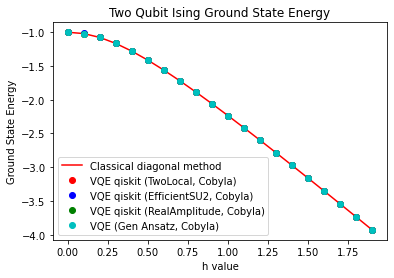

In [28]:
plt.plot(hvalue, np.real(cvalue), 'r-',label='Classical diagonal method')
plt.plot(hvalue, twovalue, 'ro',label='VQE qiskit (TwoLocal, Cobyla)')
plt.plot(hvalue, effvalue, 'bo',label='VQE qiskit (EfficientSU2, Cobyla)')
plt.plot(hvalue, realvalue, 'go',label='VQE qiskit (RealAmplitude, Cobyla)')
plt.plot(hvalue, realvalue0, 'co',label='VQE (Gen Ansatz, Cobyla)')

plt.legend(loc='best')
plt.title('Two Qubit Ising Ground State Energy')
plt.ylabel('Ground State Energy')
plt.xlabel('h value')
plt.show()